In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

In [3]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda")
device

device(type='cuda')

In [8]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

In [9]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [10]:
odd_classes = [1, 3, 5, 7, 9]

def filter_odd_indices(dataset):
    indices = [i for i, (_, label) in enumerate(dataset) if label in odd_classes]
    return indices

train_indices = filter_odd_indices(train_dataset)
test_indices = filter_odd_indices(test_dataset)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [11]:
train_loader_iter = iter(train_loader)
mini_batch = next(train_loader_iter)
X, y = mini_batch[0], mini_batch[1]

X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [12]:
y

tensor([7, 9, 3, 7, 5, 7, 5, 3, 1, 9, 3, 3, 3, 7, 5, 3, 7, 1, 1, 3, 3, 3, 5, 7,
        1, 5, 1, 1, 5, 9, 5, 1, 1, 1, 1, 9, 1, 1, 1, 3, 1, 3, 5, 5, 7, 1, 3, 7,
        1, 3, 9, 1, 7, 7, 3, 9, 3, 7, 3, 1, 7, 7, 5, 7])

tensor(7)


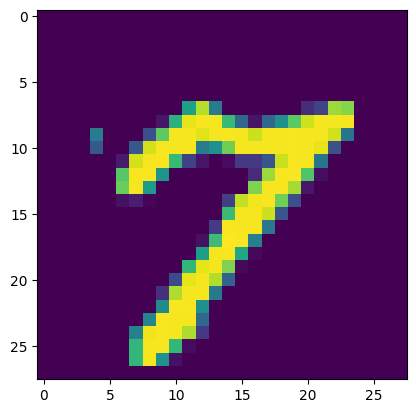

In [13]:
plt.imshow(X[0].permute(1,2,0))
print(y[0])
plt.show()

In [14]:
# MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model_odd = MLP()

# Forward test
X = torch.rand(2, 1, 28, 28)
y = model_odd(X)
y.shape

torch.Size([2, 10])

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_odd.parameters(), lr=learning_rate)

In [17]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

In [18]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=-1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return accuracy
                           

In [19]:
model_odd.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
for epoch in range(1, num_epochs + 1):
    train(model_odd, device, train_loader, optimizer, epoch)
    accuracy = test(model_odd, device, test_loader)
    print("-" * 30)

Train Epoch: 1 [0/30508 (0%)]	Loss: 2.293621
Train Epoch: 1 [6400/30508 (21%)]	Loss: 0.330007
Train Epoch: 1 [12800/30508 (42%)]	Loss: 0.275300
Train Epoch: 1 [19200/30508 (63%)]	Loss: 0.103199
Train Epoch: 1 [25600/30508 (84%)]	Loss: 0.070082

Test set: Average loss: 0.0013, Accuracy: 29711/30508 (97%)

------------------------------
Train Epoch: 2 [0/30508 (0%)]	Loss: 0.081466
Train Epoch: 2 [6400/30508 (21%)]	Loss: 0.010960
Train Epoch: 2 [12800/30508 (42%)]	Loss: 0.094521
Train Epoch: 2 [19200/30508 (63%)]	Loss: 0.143333
Train Epoch: 2 [25600/30508 (84%)]	Loss: 0.025703

Test set: Average loss: 0.0009, Accuracy: 30044/30508 (98%)

------------------------------
Train Epoch: 3 [0/30508 (0%)]	Loss: 0.027707
Train Epoch: 3 [6400/30508 (21%)]	Loss: 0.005694
Train Epoch: 3 [12800/30508 (42%)]	Loss: 0.014670
Train Epoch: 3 [19200/30508 (63%)]	Loss: 0.024490
Train Epoch: 3 [25600/30508 (84%)]	Loss: 0.023919

Test set: Average loss: 0.0006, Accuracy: 30110/30508 (99%)

--------------------

In [21]:
torch.save(model_odd.state_dict(), "model_mnist_odd.pth")

In [22]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader_iter = iter(train_loader)

In [23]:
class LoRA(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha=None):
        super().__init__()
        self.r = r

        if alpha is None:
            self.alpha = r
        else:
            self.alpha = alpha

        self.lora_A = nn.Linear(in_features, r, bias=False)
        self.lora_B = nn.Linear(r, out_features, bias=False)

        # B = 0
        nn.init.zeros_(self.lora_B.weight)

        # scaler
        self.scale = self.alpha / r

    def forward(self, x):
        output = self.lora_B(self.lora_A(x)) * self.scale
        return output

In [47]:
class MLPwithLoRA(nn.Module):
    def __init__(self, lora_config):
        super().__init__()

        self.loca_config = lora_config

        r = lora_config['r']
        lora_alpha = lora_config['alpha']

        self.fc1 = nn.Linear(28*28, 256)
        self.fc1_lora = LoRA(28*28, 256, r=r, alpha=lora_alpha)

        self.fc2 = nn.Linear(256, 128)
        self.fc2_lora = LoRA(256, 128, r=r, alpha=lora_alpha)

        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x) + self.fc1_lora(x))
        x = torch.relu(self.fc2(x) + self.fc2_lora(x))
        x = self.fc3(x)
        return x

    def save_trainable_parameters(self, file_path):
        trainable_state_dict= {
            name:param for name, param in self.named_parameters() if param.requires_grad
        }

        trainable_state_dict['alpha'] = self.loca_config['alpha']
        trainable_state_dict['r'] = self.loca_config['r']

        torch.save(trainable_state_dict, file_path)

In [48]:
model_lora = MLPwithLoRA(lora_config={'r': 4, 'alpha': 8.0})
model_lora.to(device)

MLPwithLoRA(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc1_lora): LoRA(
    (lora_A): Linear(in_features=784, out_features=4, bias=False)
    (lora_B): Linear(in_features=4, out_features=256, bias=False)
  )
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc2_lora): LoRA(
    (lora_A): Linear(in_features=256, out_features=4, bias=False)
    (lora_B): Linear(in_features=4, out_features=128, bias=False)
  )
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [49]:
odd_state_dict = torch.load("model_mnist_odd.pth", weights_only=True)
model_lora.fc1.weight.data=odd_state_dict['fc1.weight']
model_lora.fc1.bias.data=odd_state_dict['fc1.bias']
model_lora.fc2.weight.data=odd_state_dict['fc2.weight']
model_lora.fc2.bias.data=odd_state_dict['fc2.bias']
model_lora.fc3.weight.data=odd_state_dict['fc3.weight']
model_lora.fc3.bias.data=odd_state_dict['fc3.bias']

for param in model_lora.fc1.parameters():
    param.requires_grad = False
for param in model_lora.fc2.parameters():
    param.requires_grad = False
for param in model_lora.fc3.parameters():
    param.requires_grad = False

for param in model_lora.fc1_lora.parameters():
    param.requires_grad = True
for param in model_lora.fc2_lora.parameters():
    param.requires_grad = True

In [34]:
X = torch.rand(2, 1, 28, 28).to(device)
y = model_lora(X)
y.shape

torch.Size([2, 10])

In [50]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model_lora)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Ratio of trainable parameters: {(trainable_params/total_params)*100:.3}%")

Total parameters: 240842
Trainable parameters: 5696
Ratio of trainable parameters: 2.37%


In [51]:
numbers = [1,2,3,4,5,6,7,8,9,10]
even_numbers = filter(lambda x: x % 2 == 0, numbers)
print(list(even_numbers))

print(
    len(list(model_lora.parameters())), # 전체 5개의 Linear에서 w, b가 있으므로 10개
    len(list(filter(lambda p: p.requires_grad, model_lora.parameters()))) # lora adapter 2개에서 A, B 있으므로 4개
)

[2, 4, 6, 8, 10]
10 4


In [52]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_lora.parameters()),
    lr=learning_rate
)

In [53]:
for params in optimizer.param_groups[0]["params"]:
    print(params.shape)

torch.Size([4, 784])
torch.Size([256, 4])
torch.Size([4, 256])
torch.Size([128, 4])


In [ ]:
for epoch in range(1, num_epochs+1):
    train(model_lora, device, train_loader, optimizer, epoch)
    accuracy = test(model_lora, device, test_loader)
    print("-" * 30)

Train Epoch: 1 [0/60000 (0%)]	Loss: 11.830862
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.398032
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.040664
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.756486
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.647018
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.569160
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.369654
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.236448
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.298132
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.229623

Test set: Average loss: 0.0048, Accuracy: 54799/60000 (91%)

------------------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.209692
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.158789
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.286688
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.144957
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.166203
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.369170
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.142362
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.362621
Train Epoch: 2 [51

In [41]:
test(model_odd, device, test_loader)
test(model_lora, device, test_loader)


Test set: Average loss: 0.1404, Accuracy: 30403/60000 (51%)


Test set: Average loss: 0.0011, Accuracy: 58713/60000 (98%)



97.855

In [42]:
# LoRA 파라미터 저장
model_lora.save_trainable_parameters("model_lora_trainable.pth")

In [43]:
new_model = MLP()

odd_state_dict = torch.load("model_mnist_odd.pth", weights_only=True)
new_model.fc1.weight.data=odd_state_dict['fc1.weight']
new_model.fc1.bias.data=odd_state_dict['fc1.bias']
new_model.fc2.weight.data=odd_state_dict['fc2.weight']
new_model.fc2.bias.data=odd_state_dict['fc2.bias']
new_model.fc3.weight.data=odd_state_dict['fc3.weight']
new_model.fc3.bias.data=odd_state_dict['fc3.bias']

In [44]:
test(new_model, device, test_loader)


Test set: Average loss: 0.1404, Accuracy: 30403/60000 (51%)



50.67166666666667

In [46]:
lora_state_dict = torch.load("model_lora_trainable.pth")
for k in lora_state_dict.keys():
    if "weight" in k:
        print(f"{k}: {lora_state_dict[k].shape}")
    else:
        print(f"{k}: {lora_state_dict[k]}")

alpha: 8.0
r: 4


In [ ]:
def merge_lora_weights(model_base, lora_params):
    a = lora_params['alpha']
    r = lora_params['r']

    lora_A_fc1 = lora_params['fc1_lora.lora_A.weight']